In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from tqdm import tqdm
import joblib


def seedEverything(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed=42
seedEverything(seed)

fontSizeSetLarge=18
fontSizeSetMedium=14
signalLims=[(0,50000),(0,5000), (0,2500), (0,4500)]
pceLims=(5,17.5)
vocLims=(0.9,1.15)
jscLims=(16,22)
ffLims=(40,75)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
filename='data/data.h5'

## read in and preprocess data

In [3]:
# Read the HDF5 file into a DataFrame
readDF=pd.read_hdf(filename, 'df') 
# Filter the DataFrame based on date, standard ratio, and standard molarity
readDF=readDF[(readDF["date"]>20230724) &(readDF["ratio"]==1) & (readDF["molarity"]==0.67)]

# List of signal types to process
signals=["ND","LP725","LP780","SP775"]

# Pad signals in the DataFrame to have the same length (1979)
for iy, signal in enumerate(signals):
    for ix in range(len(readDF)):
        temp1=readDF.loc[readDF.index[ix],signal]
        
        # Calculate how much padding is required and perform padding
        values_to_add = 1979 - len(temp1)
        constant_value = 0  
        temp1_padded = np.concatenate((temp1, [constant_value] * values_to_add))
        
        # Update the DataFrame with padded signals
        readDF.at[readDF.index[ix],signal]=temp1_padded
        
# Define samples that will be used as training data        
train_samples=[ 'DHM', 'DHN', 'DHO', 'DHP', 'DHQ' ,'DHR' ,
               'DGS', 'DGT', 'DGU' ,'DGV', 'DGW', 'DGX','DHS', 
               'DFS','DFT', 'DFU' ,'DFV', 'DFW' ,'DFX','DGR',
               'DEV' ,'DEW', 'DEX' ,'DFQ', 'DFR' ,'DGP','DGQ',
               'DAC', 'DAH' ,'DAM', 'DBC' ,'DBH', 'DBM', 'DBR', 'DCA', 'DCI', 'DDM', 'DDN' ,'DDO',
               'DDP', 'DDQ', 'DDR' ,'DDS' ,'DDT', 'DDU' ,'DDV', 'DDW' ,'DDX', 'DEM', 'DEN',
               'DES' ,'DET', 'DEU', 'DFO', 'DFP','DGM', 'DHV', 'DHW', 'DHX', 'DIU', 'DIV' ]

# Define sub-lists for different training folds during 5-fold cross-validation
train_fold0_sub_list=['DHM',  'DHR',  'DGW',  'DFU', 'DEV',  'DGP', 'DFO', 'DHX', 'DDO',  'DDT', 'DEM' ]
train_fold1_sub_list=[ 'DHN', 'DGS', 'DGX' , 'DFV', 'DEW', 'DGQ',  'DFP',  'DIU', 'DDP', 'DDU', 'DEN']
train_fold2_sub_list=[ 'DHO',  'DGT' , 'DHS',  'DFW', 'DEX', 'DES',  'DGM',  'DIV',  'DDQ',  'DDV']
train_fold3_sub_list=[ 'DHP', 'DGU', 'DFS' ,  'DFX' ,  'DFQ',  'DET', 'DHV', 'DDM', 'DDR',  'DDW']
train_fold4_sub_list=[ 'DHQ',  'DGV', 'DFT', 'DGR', 'DFR', 'DEU', 'DHW',  'DDN', 'DDS',  'DDX'  ]

# Drop samples not in any fold from the training DataFrame and reset its index
indexDropTrain = readDF[ ~readDF['expID'].isin(train_fold0_sub_list+train_fold1_sub_list+train_fold2_sub_list+train_fold3_sub_list+train_fold4_sub_list ) ].index
trainDF=readDF.drop(indexDropTrain)
trainDF=trainDF.reset_index(drop=True)

# Assigning fold numbers to each sample in trainDF
for element in trainDF[trainDF['expID'].isin(train_fold0_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=0
for element in trainDF[trainDF['expID'].isin(train_fold1_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=1
for element in trainDF[trainDF['expID'].isin(train_fold2_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=2
for element in trainDF[trainDF['expID'].isin(train_fold3_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=3
for element in trainDF[trainDF['expID'].isin(train_fold4_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=4
    
# Drop the train samples from the DataFrame to create a test set and reset its index
indexDropTest = readDF[ readDF['expID'].isin(train_samples) ].index
testDF=readDF.drop(indexDropTest)
testDF=testDF.reset_index(drop=True)

def filter(df):
    # Filter out rows where 'PCE_backward' is not available
    df=df[df['PCE_backward'].notna()]
    
    # Set threshold for 'PCE_backward' to be used
    thres_PCE=1
    
    # Filter the DataFrame to include only rows where 'PCE_backward' is larger than the threshold
    if thres_PCE>0:
        df=df[df['PCE_backward']>thres_PCE]
    
    df=df.reset_index(drop=True)
    
    return df

# Apply the `filter` function to the training and testing DataFrames.
# This ensures that only entries with 'PCE_backward' values above the threshold are retained.
trainDF, testDF = [filter(df) for df in (trainDF, testDF)]  

## load NN model and random forests

In [4]:
# Definition of a neural network model
class NN_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN_Model, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 500)
        self.fc3 = nn.Linear(500, 1000)
        self.fc4 = nn.Linear(1000, 500)
        self.fc5 = nn.Linear(500, 200)
        self.fc6 = nn.Linear(200, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)

        return x

# load the NN model
input_size=7916
output_size=1
model = NN_Model(input_size, output_size).to(device)
model.load_state_dict(torch.load("models/regression_model/model_weights.pth"))
model.eval()

NN_Model(
  (fc1): Linear(in_features=7916, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=500, bias=True)
  (fc5): Linear(in_features=500, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=1, bias=True)
  (relu): ReLU()
)

In [5]:
# Generate color maps for plotting
ks = np.linspace(0.2,0.99,7)
ks2 = np.linspace(0.5,0.99,7)
color_list_fig = []
color_list_fig_2 = []
cmap = plt.get_cmap('Reds')
cmap2 = plt.get_cmap('Blues')
for zz in range(len(ks)):
    color_list_fig.append(cmap(ks[zz]))
    color_list_fig_2.append(cmap2(ks2[zz]))
# Define lists and parameters needed for plotting
scaler=2**16
xticks=[20,30,60,120,180,240,600]
markerlist=["o","x","s","D","v","*","p"]   
ventings_in_s=["20s","30s","60s","120s","180s","240s","600s"]
evac_durations=sorted(trainDF["evac_duration"].unique())
ventings=[29,59,149,329,509,689,1769]
signals=["ND", "LP725","LP780","SP775"] 

# check if all random forest models have been trained and already exist
for signal in signals:
    for ix, venting in enumerate(ventings):  
        for iy, evac_duration in enumerate(evac_durations[ix:]):            
            temp = trainDF[trainDF["evac_duration"]==evac_duration]           
            modelsavepath="models/forecasting_models/" +str(signal)+"_"+ str(venting)+"_"+str(evac_duration)+".joblib"
            
            if os.path.isfile(modelsavepath) == True:
                pass
            else:
                print("needs to be trained: ", signal, venting, evac_duration, "no_of_samples:", len(temp))
                
print("all models already exist")

all models already exist


## Assessing accuracy of the model cascade used for forecasting and predicting PCE

In [6]:
# Initialize DataFrame to store the aggregated results
columnNames=["expID","patchID","GT PCE","GT Venting","predictions_of_diff_quenchTimes"]
dataFrame=pd.DataFrame(columns=columnNames)

# Iterate over each unique experiment ID from the test dataset
for i_exp,expID in enumerate(sorted(testDF["expID"].unique())):
    print(i_exp, sorted(testDF["expID"].unique())[i_exp])
    # Filter the test dataset for the current experiment ID
    testingData=testDF[testDF["expID"]==sorted(testDF["expID"].unique())[i_exp]]
    
    # Process each sample within the filtered testing data    
    for inn in tqdm(range(len(testingData))):
        # Extract details of the current test sample
        testsample=testingData.loc[testingData.index[inn]]
        patchID=testsample["patchID"]
        sample_evac_duration= testsample["evac_duration"]
        gt_pce= testsample["PCE_backward"]

        # Initialize a list to store predictions for different quenching times
        predictions_of_diff_quenchTimes=[]

        # Loop through venting times, up to the current sample's ground truth evacuation duration
        for ix, venting in enumerate(ventings[:evac_durations.index(sample_evac_duration)+1]):
            # Initialize scaffolds for signals and their oscillations after venting
            scaffold_signals=[[],[],[],[]]
            scaffold_signals_oscillation=[[],[],[],[]]
            
            # Iterate over each signal type
            for i_signal, signal in enumerate(signals):

                ls_preds=[]
                list_endOscillation=[]   
                for iy, evac_duration in enumerate([sample_evac_duration]):
                    # Load the Random Forest model
                    modelsavepath="models/forecasting_models/" +str(signal)+"_"+ str(venting)+"_"+str(evac_duration)+".joblib"
                    rf_model = joblib.load(modelsavepath)
                    
                    # Extract the factual data up to the venting time
                    factual=testsample[signal][:venting]
                    # Predict/Forecast future signal values using the Random Forest model
                    y_pred=rf_model.predict([factual])
                    
                    # Adjust the prediction to align with the last known value
                    curve=y_pred[0]
                    slope=factual[-1]-factual[-2]
                    delta=curve[0]-(factual[-1]+slope)
                    y_pred[0]=curve-delta
                
                    # Store the predictions/forecasts
                    ls_preds.append(y_pred[0])
                    list_endOscillation.append(y_pred[0][-210:])
                    
                # Combine the factual data and forecast into a complete signal for each sample
                for plotParam in range(len(ls_preds)):
                    scaffold_signal=np.concatenate((factual,ls_preds[plotParam],[0]*(1979-len(factual)-len(ls_preds[plotParam]))))
                    scaffold_signals[i_signal].append(scaffold_signal)
                    scaffold_signals_oscillation[i_signal].append(ls_preds[plotParam])
                    
            # Generate predictions using the neural network model for the combined signals (input + forecasted signal)                  
            list_of_predictions_scaffold=[]
            for i_gneratedSignal in range(len(scaffold_signals[0])):
                forecastedSignal=np.hstack((scaffold_signals[0][i_gneratedSignal],scaffold_signals[1][i_gneratedSignal],scaffold_signals[2][i_gneratedSignal],scaffold_signals[3][i_gneratedSignal]))/scaler
                pred_forecastedSignal=model(torch.tensor(forecastedSignal.astype(np.float32)).to(device)).cpu().detach().numpy() [0]
                list_of_predictions_scaffold.append(pred_forecastedSignal)
                
            # Append the neural network model's predictions to the list for different quenching times
            predictions_of_diff_quenchTimes.append(list_of_predictions_scaffold[0])
            
        # Create a new row with the experiment details and predictions, and append it to the DataFrame
        dataNew=[(expID,patchID,gt_pce,evac_duration,predictions_of_diff_quenchTimes)]
        dfnew=pd.DataFrame(dataNew, columns=columnNames)
        dataFrame = pd.concat([dataFrame, dfnew], ignore_index=True)

0 DEO


  0%|          | 0/24 [00:00<?, ?it/s]/scratch/slurm_tmpdir/job_1419220/ipykernel_375573/3351602922.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataFrame = pd.concat([dataFrame, dfnew], ignore_index=True)
100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


1 DEP


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


2 DEQ


100%|██████████| 32/32 [00:37<00:00,  1.16s/it]


3 DER


100%|██████████| 32/32 [00:36<00:00,  1.16s/it]


4 DFM


100%|██████████| 29/29 [00:34<00:00,  1.18s/it]


5 DFN


100%|██████████| 32/32 [00:37<00:00,  1.16s/it]


6 DGN


100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


7 DGO


100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


8 DHT


100%|██████████| 31/31 [00:36<00:00,  1.18s/it]


9 DHU


100%|██████████| 32/32 [00:11<00:00,  2.71it/s]


10 DIM


100%|██████████| 31/31 [00:00<00:00, 38.96it/s]


11 DIN


100%|██████████| 32/32 [00:00<00:00, 44.20it/s]


12 DIO


100%|██████████| 31/31 [00:07<00:00,  3.89it/s]


13 DIP


100%|██████████| 31/31 [00:07<00:00,  4.06it/s]


14 DIQ


100%|██████████| 31/31 [00:18<00:00,  1.70it/s]


15 DIR


100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


16 DIS


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


17 DIT


100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


18 DIW


100%|██████████| 31/31 [01:17<00:00,  2.51s/it]


19 DIX


100%|██████████| 32/32 [01:20<00:00,  2.50s/it]


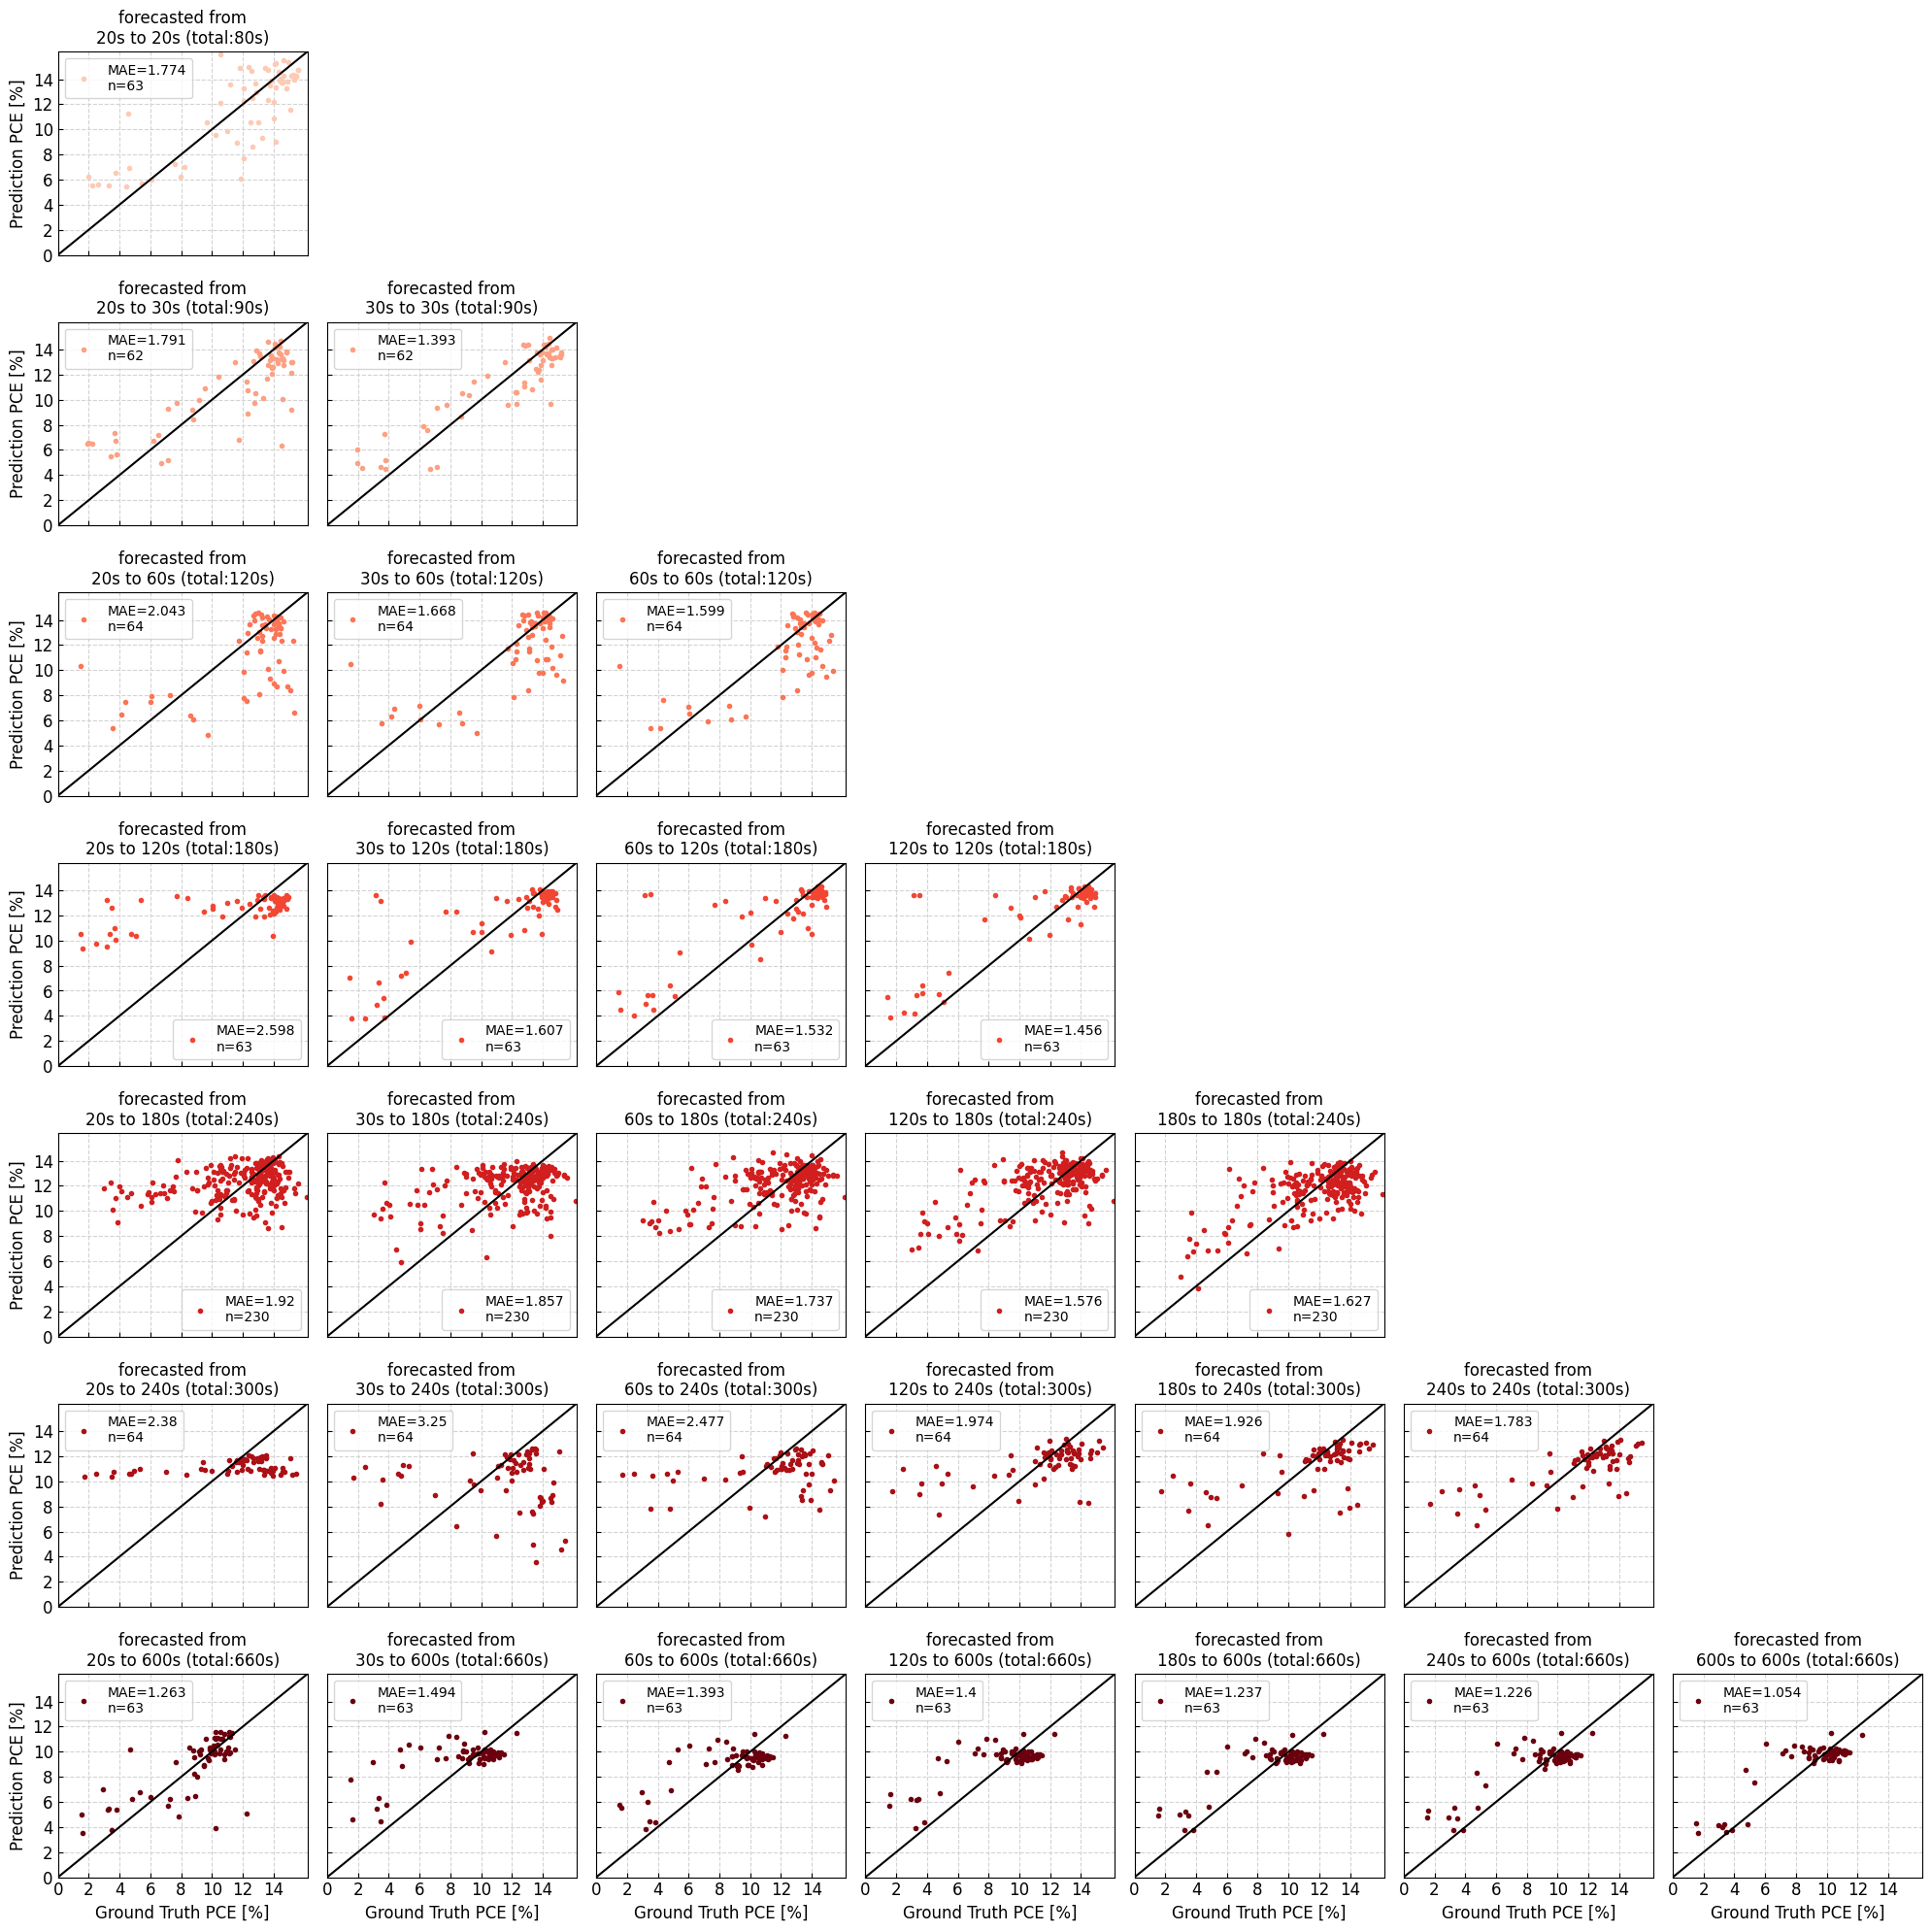

In [7]:
fig,ax= plt.subplots(7,7, figsize=(20,20),sharex=True, sharey=True)

# Loop over each unique "GT Venting" time in the sorted order
for i_venting, gt_venting in enumerate(sorted(dataFrame["GT Venting"].unique())):
    # Filter the DataFrame for the current venting time
    temp= dataFrame[dataFrame["GT Venting"]==gt_venting]
    
    # Initialize a list of lists to store predictions for each venting time up to the current one  
    ls=[[] for i in range(i_venting+1)]
    for imm in range(i_venting+1):
        for inn in range(len(temp)):
            # Append the prediction for the current venting time from each row in the temp DataFrame
            ls[imm].append(temp.loc[temp.index[inn], "predictions_of_diff_quenchTimes"][imm])
            
    # Loop over each set of predictions to plot against the ground truth PCE
    for ixx in range(len(ls)):
        # Calculate the mean absolute error between the ground truth and predictions 
        mae=np.round(mean_absolute_error(temp["GT PCE"].tolist(), ls[ixx]),3)
        
        # Scatter plot the ground truth vs predictions
        ax[i_venting,ixx].plot(temp["GT PCE"].tolist(), ls[ixx], '.',color=color_list_fig[len(ls)-1], label="MAE="+str(mae)+"\nn="+str(len(temp["GT PCE"].tolist())))
        ax[i_venting,ixx].axline((10, 10), slope=1, color='k')
        ax[i_venting,ixx].set_ylim(0,16.2)
        ax[i_venting,ixx].set_xlim(0,16.2)
        ax[i_venting,ixx].set_xticks([0,2,4,6,8,10,12,14])
        ax[i_venting,ixx].set_yticks([0,2,4,6,8,10,12,14])
        ax[i_venting,ixx].legend()
        ax[i_venting,ixx].grid(which="both", linestyle='--', color="lightgrey")
        ax[i_venting,ixx].tick_params(axis='both', which='major',direction="in", labelsize=12) 
        ax[i_venting,ixx].set_title("forecasted from\n"+ str(ventings_in_s[ixx]) +" to " +str(ventings_in_s[len(ls)-1])+ " (total:"+ str(int(gt_venting/3))+"s)")
        
for i in range(7):
    ax[i,0].set_ylabel("Prediction PCE [%]", fontsize=12)
    ax[6,i].set_xlabel("Ground Truth PCE [%]", fontsize=12)   
for i in range(6):
    fig.delaxes(ax[0][i+1])
for i in range(5):
    fig.delaxes(ax[1][i+2])
for i in range(4):
    fig.delaxes(ax[2][i+3])
for i in range(3):
    fig.delaxes(ax[3][i+4])
for i in range(2):
    fig.delaxes(ax[4][i+5])
fig.delaxes(ax[5][6])
plt.tight_layout()    
plt.show()


## Forecasting and predicting PCE -- comparing prediction accuracy for forecasting at different times during the experiment

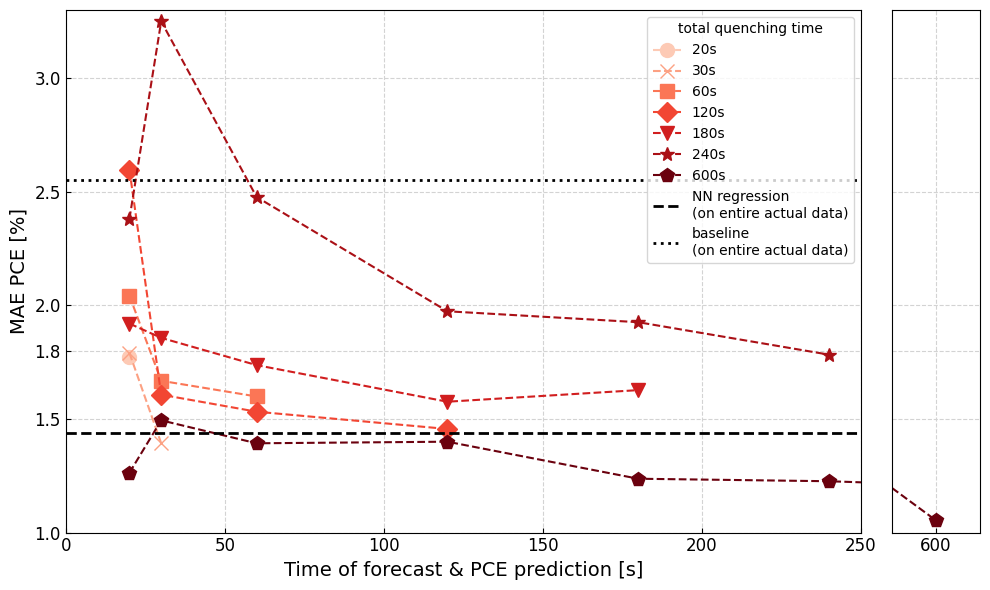

In [8]:
# Initialize a list of lists to store MAE for each venting time
mae_list=[[] for i in range(7)]

# Iterate over each unique ground truth venting time
for i_venting, gt_venting in enumerate(sorted(dataFrame["GT Venting"].unique())):
    # Filter the DataFrame for the current venting time
    temp= dataFrame[dataFrame["GT Venting"]==gt_venting]
    
    # Initialize a list of lists for storing predictions for each venting time up to the current one
    ls=[[] for i in range(i_venting+1)]
    
    # Collect predictions for each venting time
    for imm in range(i_venting+1):
        for inn in range(len(temp)):
            ls[imm].append(temp.loc[temp.index[inn], "predictions_of_diff_quenchTimes"][imm])
            
    # Calculate MAE for each set of predictions and store it in the mae_list
    for ixx in range(len(ls)):
        mae=np.round(mean_absolute_error(temp["GT PCE"].tolist(), ls[ixx]),3)
        mae_list[i_venting].append(mae)


# Plot MAE for each venting time across different forecast times
fig,ax=plt.subplots(1,2,figsize=(10,6),sharey=True,gridspec_kw={'width_ratios': [9, 1]})
for ixx in range(7):
    ax[0].plot(xticks[:ixx+1], mae_list[ixx],marker=markerlist[ixx],linestyle="--", color= color_list_fig[ixx], markersize=10, label=ventings_in_s[ixx]) 
ax[1].plot(xticks, mae_list[-1],"p--", color= color_list_fig[6], markersize=10)
# Add horizontal lines representing the neural network regression on the actual data and the baselineon the actual data 
ax[0].axhline(1.44, color="k", linestyle="--", linewidth=2, label="NN regression\n(on entire actual data)")
ax[0].axhline(2.55, color="k", linestyle=":", linewidth=2, label="baseline\n(on entire actual data)")
ax[0].set_ylabel("MAE PCE [%]", fontsize=14)
ax[0].set_xlabel("Time of forecast & PCE prediction [s]", fontsize=14)
ax[0].grid(which="both", linestyle='--', color="lightgrey")
ax[1].grid(which="both", linestyle='--', color="lightgrey")
ax[0].tick_params(axis='both', which='major',direction="in", labelsize=12) 
ax[1].tick_params(axis='x', which='major',direction="in", labelsize=12) 
ax[1].tick_params(left=False) 
ax[0].set_ylim(1,3.3)
ax[0].set_xlim(0,250)
ax[1].set_xlim(300,900)
ax[1].set_xticks([600])
ax[0].set_yticks([1,1.5,1.8,2,2.5,3])
ax[0].legend(title="total quenching time")
plt.tight_layout()
plt.show()

# Forecasting and predicting PCE "what-if" scenarios for two different solar cell pixels

DFM 82


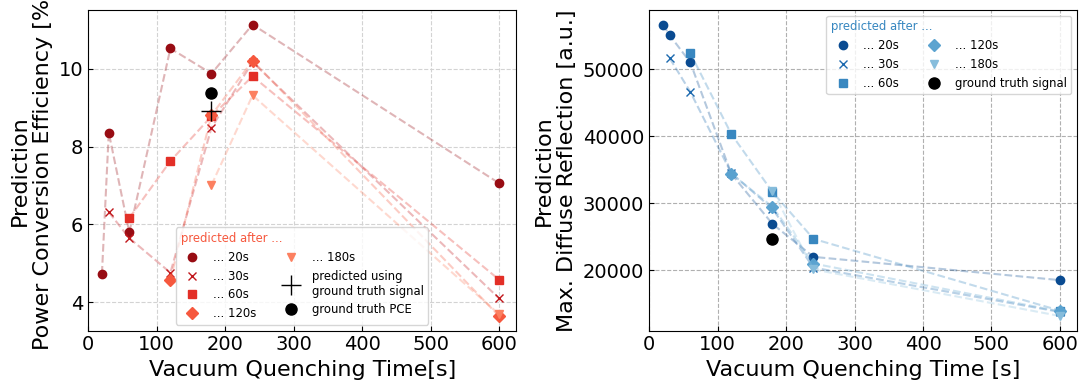

DGN 42


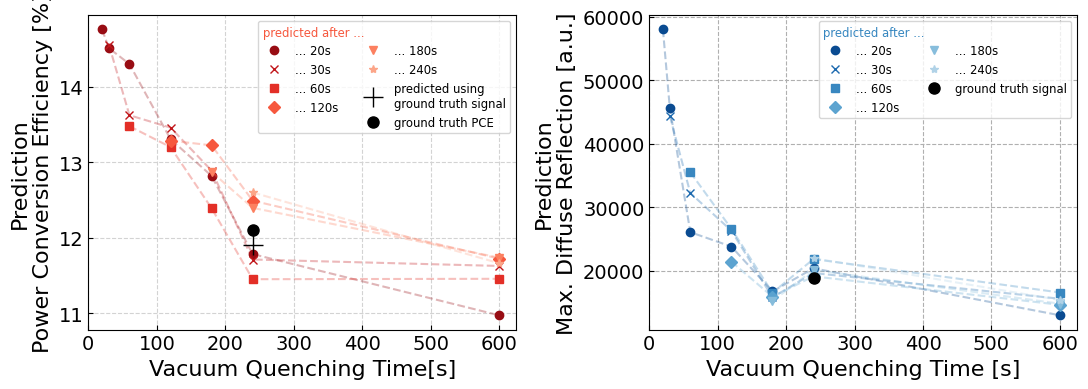

In [9]:
# Generate color maps for plotting
ks = np.linspace(0.1,0.8,len(testDF["evac_duration"].unique()))
ks2 = np.linspace(0.1,0.8,len(testDF["evac_duration"].unique()))
color_list_fig = []
color_list_fig_2 = []
cmap = plt.get_cmap('Reds_r')
cmap2 = plt.get_cmap('Blues_r')
for zz in range(len(ks)):
    color_list_fig.append(cmap(ks[zz]))
    color_list_fig_2.append(cmap2(ks2[zz]))
    
cnt=0
# Loop through each unique experiment ID in the test dataset
for i_exp in range(len(sorted(testDF["expID"].unique()))):
    # Filter the test data for the current experiment
    testingData=testDF[testDF["expID"]==sorted(testDF["expID"].unique())[i_exp]]
    # List of specific experiments of interest
    listOfInterest=["DGN","DFM"]
    # Check if the current experiment is of interest
    if sorted(testDF["expID"].unique())[i_exp] in listOfInterest:
            
        cnt+=1
        for inn in range(len(testingData)):
            # Extract the test sample
            testsample=testingData.loc[testingData.index[inn]]
                        
            patchID=testsample["patchID"]
            # Specify patches of interest based on the experiment counter
            if cnt==1:
                listOfInterest2=[82]
            elif cnt==2:
                listOfInterest2=[42]
            else: 
                break
            # Check if the current patch is of interest
            if patchID in listOfInterest2:
                print(testsample["expID"], testsample["patchID"])
                # Retrieve sample details
                sample_evac_duration= int(testsample["evac_duration"])                                                 
                gt_pce= testsample["PCE_backward"]
                gt_signal= np.max(testsample["ND"][int(testsample["evac_duration"])-212:int(testsample["evac_duration"])-1])
                actualSignal=np.hstack((testsample["ND"],testsample["LP725"],testsample["LP780"],testsample["SP775"]))/scaler
                pred_realSignal=model(torch.tensor(actualSignal.astype(np.float32)).to(device)).cpu().detach().numpy() [0]
                
                # Loop through the venting times up to the sample's evacuation duration
                fig1,ax1=plt.subplots(1,2,figsize=(11,4))
                for ix, venting in enumerate(ventings[:evac_durations.index(sample_evac_duration)+1]):
                    # Initialize scaffolds for signals and their oscillations after venting           
                    scaffold_signals=[[],[],[],[]]
                    scaffold_signals_oscillation=[[],[],[],[]]
                    
                    # Iterate over each signal type
                    for i_signal, signal in enumerate(signals):
        
                        ls_preds=[]
                        list_endOscillation=[]   
                        for iy, evac_duration in enumerate(evac_durations[ix:]):
                            # Load the Random Forest model
                            modelsavepath="models/forecasting_models/" +str(signal)+"_"+ str(venting)+"_"+str(evac_duration)+".joblib"
                            rf_model = joblib.load(modelsavepath)
                            
                            # Extract the factual data up to the venting time
                            factual=testsample[signal][:venting]
                            # Predict/Forecast future signal values using the Random Forest model
                            y_pred=rf_model.predict([factual])
                            
                            # Adjust the prediction to align with the last known value
                            curve=y_pred[0]
                            slope=factual[-1]-factual[-2]
                            delta=curve[0]-(factual[-1]+slope)
                            y_pred[0]=curve-delta
                                
                            # Store the predictions/forecasts
                            ls_preds.append(y_pred[0])
                            list_endOscillation.append(y_pred[0][-210:])
                                                        
                        # Combine the factual data and forecast into a complete signal for each sample
                        for plotParam in range(len(ls_preds)):
                            scaffold_signal=np.concatenate((factual,ls_preds[plotParam],[0]*(1979-len(factual)-len(ls_preds[plotParam]))))
                            scaffold_signals[i_signal].append(scaffold_signal)
                            scaffold_signals_oscillation[i_signal].append(ls_preds[plotParam])
                    
                    # Generate predictions using the neural network model for the combined signals (input + forecasted signal)                  
                    list_of_predictions_scaffold=[]
                    for i_gneratedSignal in range(len(scaffold_signals[0])):
                        forecastedSignal=np.hstack((scaffold_signals[0][i_gneratedSignal],scaffold_signals[1][i_gneratedSignal],scaffold_signals[2][i_gneratedSignal],scaffold_signals[3][i_gneratedSignal]))/scaler
                        pred_forecastedSignal=model(torch.tensor(forecastedSignal.astype(np.float32)).to(device)).cpu().detach().numpy() [0]
                        list_of_predictions_scaffold.append(pred_forecastedSignal)
                        
                    # Plot PCE predictions based on forecasted data                
                    ax1[0].plot(xticks[ix:],list_of_predictions_scaffold, marker=markerlist[ix],linestyle="None",color=color_list_fig[ix], label="... "+ str(xticks[ix])+"s")
                    ax1[0].plot(xticks[ix:],list_of_predictions_scaffold, "--",color=color_list_fig[ix],alpha=0.3)

                    # Generate predictions of maximum diffuse reflection using random forest model
                    list_of_signal_predictions_scaffold=[]
                    for i_gneratedSignal in range(len(scaffold_signals_oscillation[0])):
                        partOfSignal=scaffold_signals_oscillation[0][i_gneratedSignal]        
                        maxDiffuseReflection=np.max(partOfSignal)   
                        list_of_signal_predictions_scaffold.append(maxDiffuseReflection)
                    # Plot maximum diffuse reflection predictions   
                    ax1[1].plot(xticks[ix:],list_of_signal_predictions_scaffold, marker=markerlist[ix],linestyle="None",color=color_list_fig_2[ix], label="... "+ str(xticks[ix])+"s",alpha=0.99)
                    ax1[1].plot(xticks[ix:],list_of_signal_predictions_scaffold, "--",color=color_list_fig_2[ix], alpha=0.3)
                
                # Plot PCE predictions based on actual ground truth data    
                ax1[0].plot(xticks[evac_durations.index(sample_evac_duration)], pred_realSignal, "k+", markersize=14,label="predicted using\nground truth signal")
                # Plot ground truth PCE    
                ax1[0].plot(xticks[evac_durations.index(sample_evac_duration)], gt_pce, "ko", markersize=8,label="ground truth PCE")
                ax1[0].legend(ncol=2)
                leg0 =ax1[0].legend(title="predicted after ...",ncols=2, fontsize='small')
                leg0._legend_box.align = "left"
                plt.setp(leg0.get_title(),fontsize='small', color=color_list_fig[3])
                ax1[0].set_xlabel("Vacuum Quenching Time[s]", fontsize=16)
                ax1[0].set_ylabel("Prediction\nPower Conversion Efficiency [%]", fontsize=16)                       
                ax1[0].grid(which="both", linestyle='--', color="lightgrey")
                ax1[0].tick_params(axis='both', which='major',direction="in", labelsize=14) 
                ax1[0].set_xlim(0,625)
                # Plot ground truth maximum diffuse reflection   
                ax1[1].plot(xticks[evac_durations.index(sample_evac_duration)], gt_signal, "ko", markersize=8,label="ground truth signal")
                leg1 =ax1[1].legend(title="predicted after ...",ncols=2, fontsize='small')
                leg1._legend_box.align = "left"
                plt.setp(leg1.get_title(),fontsize='small', color=color_list_fig_2[2])            
                ax1[1].set_xlabel("Vacuum Quenching Time [s]", fontsize=16)
                ax1[1].set_ylabel("Prediction\nMax. Diffuse Reflection [a.u.]", fontsize=16)                  
                ax1[1].grid(which="both", linestyle='--')
                ax1[1].tick_params(axis='both', which='major',direction="in", labelsize=14)  
                ax1[1].set_xlim(0,625)
                plt.tight_layout()
                plt.show()


# Forecasting and predicting PCE for each solar cell pixel on a large-area substrate

<p align="center">
    <img src="images/Subtrate_Map.PNG", width="400">
    <br>
    <!-- adapted from <a href="https://doi.org/10.1002/solr.202201114">original publication</a> -->
</p>

In [10]:
# Map the patch ID to physical location (coordinates) on the large-area substrate
location_dict={
    11: (3,6), 12: (2,6), 13: (3,7), 14: (2,7),
    21: (1,6), 22: (0,6), 23: (1,7), 24: (0,7),
    31: (3,4), 32: (2,4), 33: (3,5), 34: (2,5),
    41: (1,4), 42: (0,4), 43: (1,5), 44: (0,5),
    51: (3,2), 52: (2,2), 53: (3,3), 54: (2,3),
    61: (1,2), 62: (0,2), 63: (1,3), 64: (0,3),
    71: (3,0), 72: (2,0), 73: (3,1), 74: (2,1),
    81: (1,0), 82: (0,0), 83: (1,1), 84: (0,1)    
}

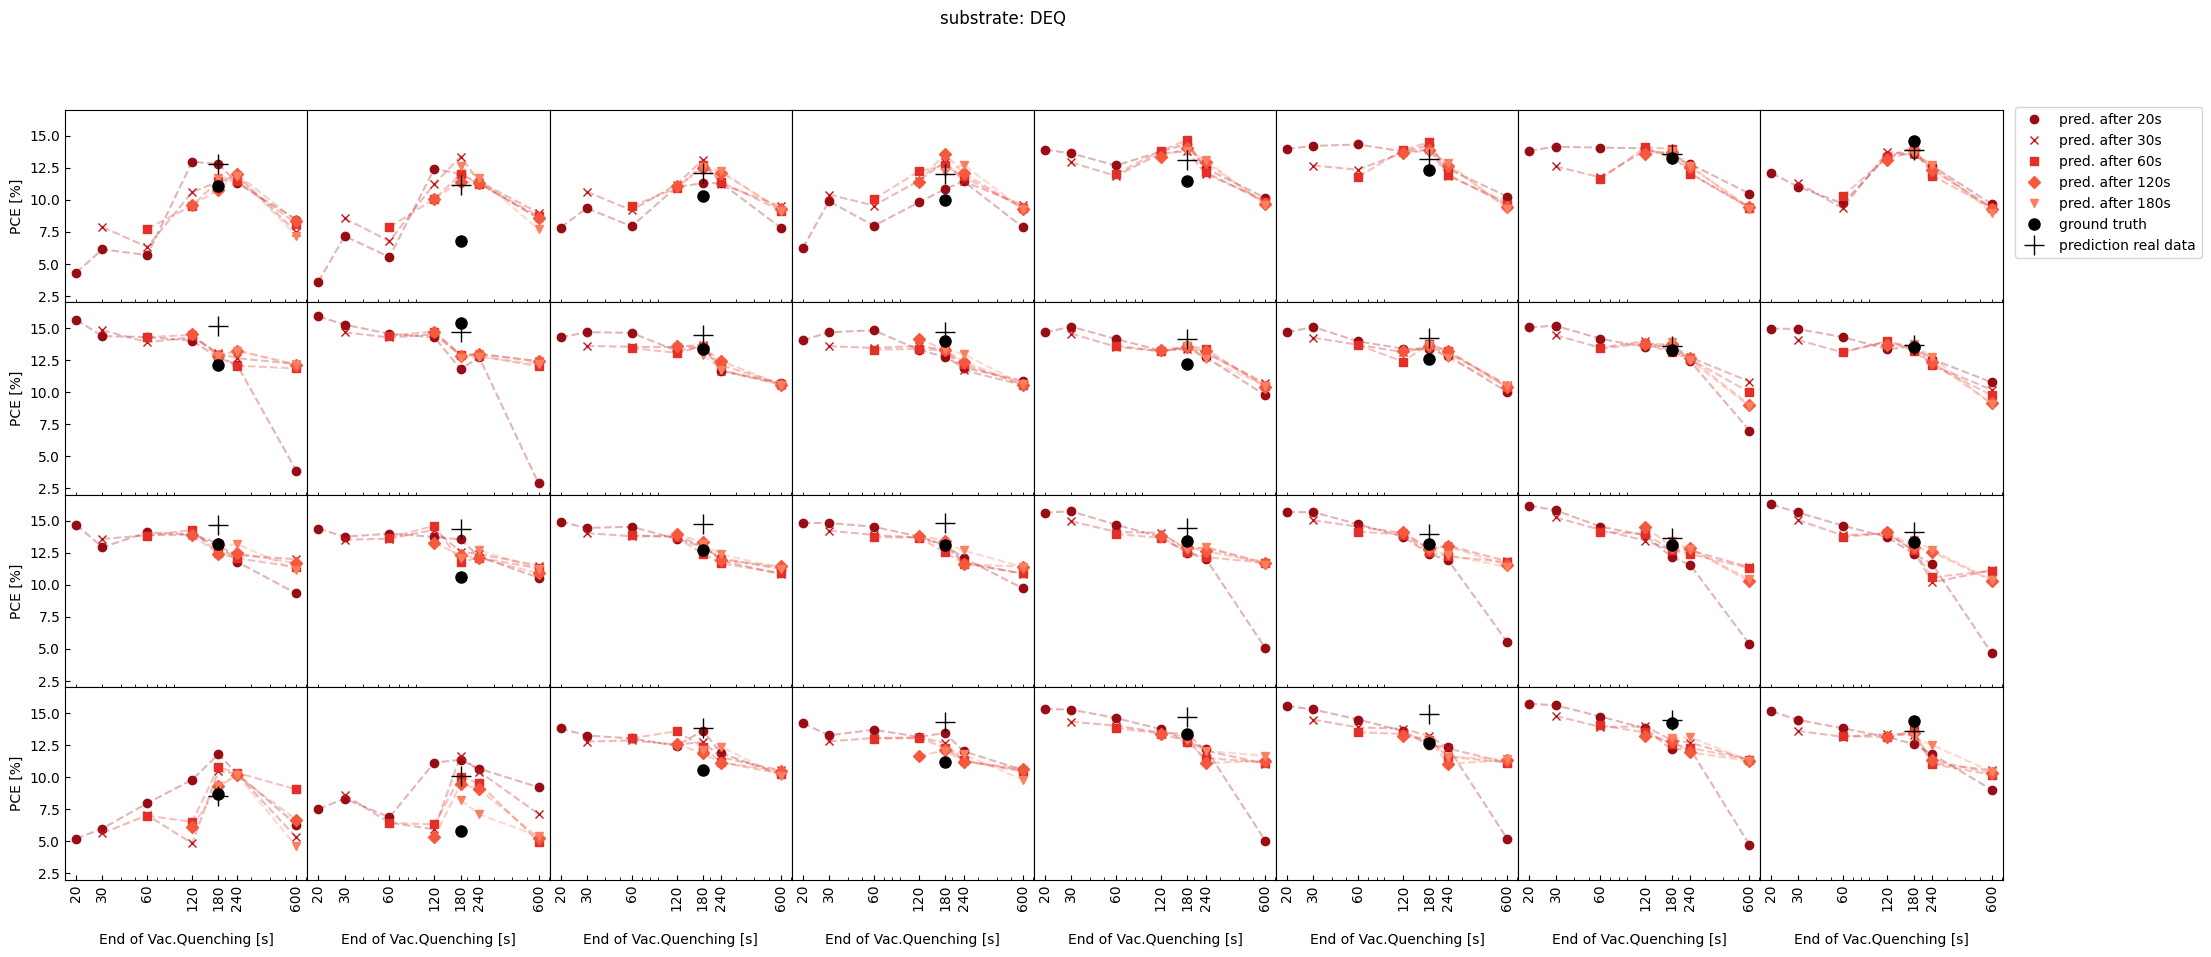

In [11]:
# Loop through each unique experiment ID in the test dataset
for i_exp in range(len(sorted(testDF["expID"].unique()))):
    # Filter the test dataset for a specific experiment ID
    if sorted(testDF["expID"].unique())[i_exp]=="DEQ":
        # Filter the test data for the current experiment
        testingData=testDF[testDF["expID"]==sorted(testDF["expID"].unique())[i_exp]]

        fig,ax =plt.subplots(4,8, figsize=(25,10))
        fig.suptitle("substrate: " +str( sorted(testDF["expID"].unique())[i_exp]))
        
        # Iterate through each sample/patch on the current expID
        for inn in range(len(testingData)):
            # Extract the test sample
            testsample=testingData.loc[testingData.index[inn]]
            
            # Retrieve sample details
            patchID=testsample["patchID"]
            sample_evac_duration= int(testsample["evac_duration"])                                                 
            gt_pce= testsample["PCE_backward"]
            # Normalize the actual signal and predict the PCE using the neural network model using the real signal
            actualSignal=np.hstack((testsample["ND"],testsample["LP725"],testsample["LP780"],testsample["SP775"]))/scaler
            pred_realSignal=model(torch.tensor(actualSignal.astype(np.float32)).to(device)).cpu().detach().numpy() [0]
            
            # Iterate over venting times up to the sample's evacuation duration
            for ix, venting in enumerate(ventings[:evac_durations.index(sample_evac_duration)+1]):
                # Initialize scaffolds for signals and their oscillations after venting             
                scaffold_signals=[[],[],[],[]]
                
                # Iterate over each signal type
                for i_signal, signal in enumerate(signals):
    
                    ls_preds=[]
                    list_endOscillation=[]   
                    for iy, evac_duration in enumerate(evac_durations[ix:]):
                        # Load the Random Forest model
                        modelsavepath="models/forecasting_models/" +str(signal)+"_"+ str(venting)+"_"+str(evac_duration)+".joblib"
                        rf_model = joblib.load(modelsavepath)
                        
                        # Extract the factual data up to the venting time
                        factual=testsample[signal][:venting]
                        # Predict/Forecast future signal values using the Random Forest model
                        y_pred=rf_model.predict([factual])
                        
                        # Adjust the prediction to align with the last known value
                        curve=y_pred[0]
                        slope=factual[-1]-factual[-2]
                        delta=curve[0]-(factual[-1]+slope)
                        y_pred[0]=curve-delta
                        
                        # Store the predictions/forecasts
                        ls_preds.append(y_pred[0])
                        list_endOscillation.append(y_pred[0][-210:])
    
                    # Combine the factual data and forecast into a complete signal for each sample
                    for plotParam in range(len(ls_preds)):
                        scaffold_signal=np.concatenate((factual,ls_preds[plotParam],[0]*(1979-len(factual)-len(ls_preds[plotParam]))))
                        scaffold_signals[i_signal].append(scaffold_signal)

                # Generate predictions using the neural network model for the combined signals (input + forecasted signal)          
                list_of_predictions_scaffold=[]
                for i_gneratedSignal in range(len(scaffold_signals[0])):
                    forecastedSignal=np.hstack((scaffold_signals[0][i_gneratedSignal],scaffold_signals[1][i_gneratedSignal],scaffold_signals[2][i_gneratedSignal],scaffold_signals[3][i_gneratedSignal]))/scaler
                    pred_forecastedSignal=model(torch.tensor(forecastedSignal.astype(np.float32)).to(device)).cpu().detach().numpy() [0]
                    list_of_predictions_scaffold.append(pred_forecastedSignal)
                
                # Plot PCE predictions based on forecasted data     
                ax[location_dict[patchID]].plot(xticks[ix:],list_of_predictions_scaffold, marker=markerlist[ix],linestyle="None",color=color_list_fig[ix], label="pred. after "+ str(xticks[ix])+"s")
                ax[location_dict[patchID]].plot(xticks[ix:],list_of_predictions_scaffold, "--",color=color_list_fig[ix],alpha=0.3)
                
            # Plot ground truth PCE        
            ax[location_dict[patchID]].plot(xticks[evac_durations.index(sample_evac_duration)], gt_pce, "ko", markersize=8,label="ground truth")
            # Plot PCE predictions based on actual ground truth data   
            ax[location_dict[patchID]].plot(xticks[evac_durations.index(sample_evac_duration)], pred_realSignal, "k+", markersize=14,label="prediction real data")
            ax[location_dict[patchID]].tick_params(axis='both', which='both',direction="in")     

        for coord in location_dict.values():
            ax[coord].set_ylim([2,17])
            ax[coord].set_xscale('log')
        for col_num in range(8):
            ax[0,col_num].set_xticks([])
            ax[1,col_num].set_xticks([])
            ax[2,col_num].set_xticks([])
            ax[3,col_num].set_xticks([])
        for col_num in range(7):
            ax[0,col_num+1].set_yticks([])
            ax[1,col_num+1].set_yticks([])
            ax[2,col_num+1].set_yticks([])
            ax[3,col_num+1].set_yticks([])
        ax[0,7].legend(bbox_to_anchor=(1.85, 1.05)) 
        for row_num in range(4):
            ax[row_num,0].set_ylabel("PCE [%]") 
        for col_num in range(8):
            ax[3,col_num].set_xlabel("\nEnd of Vac.Quenching [s]") 
            ax[3,col_num].set_xticks(xticks, labels=xticks, rotation=90, minor=False)            
        plt.subplots_adjust(wspace=0, hspace=0)     
        plt.show()

## Forecasting maximum diffuse reflection for each solar cell pixel on a large-area substrate

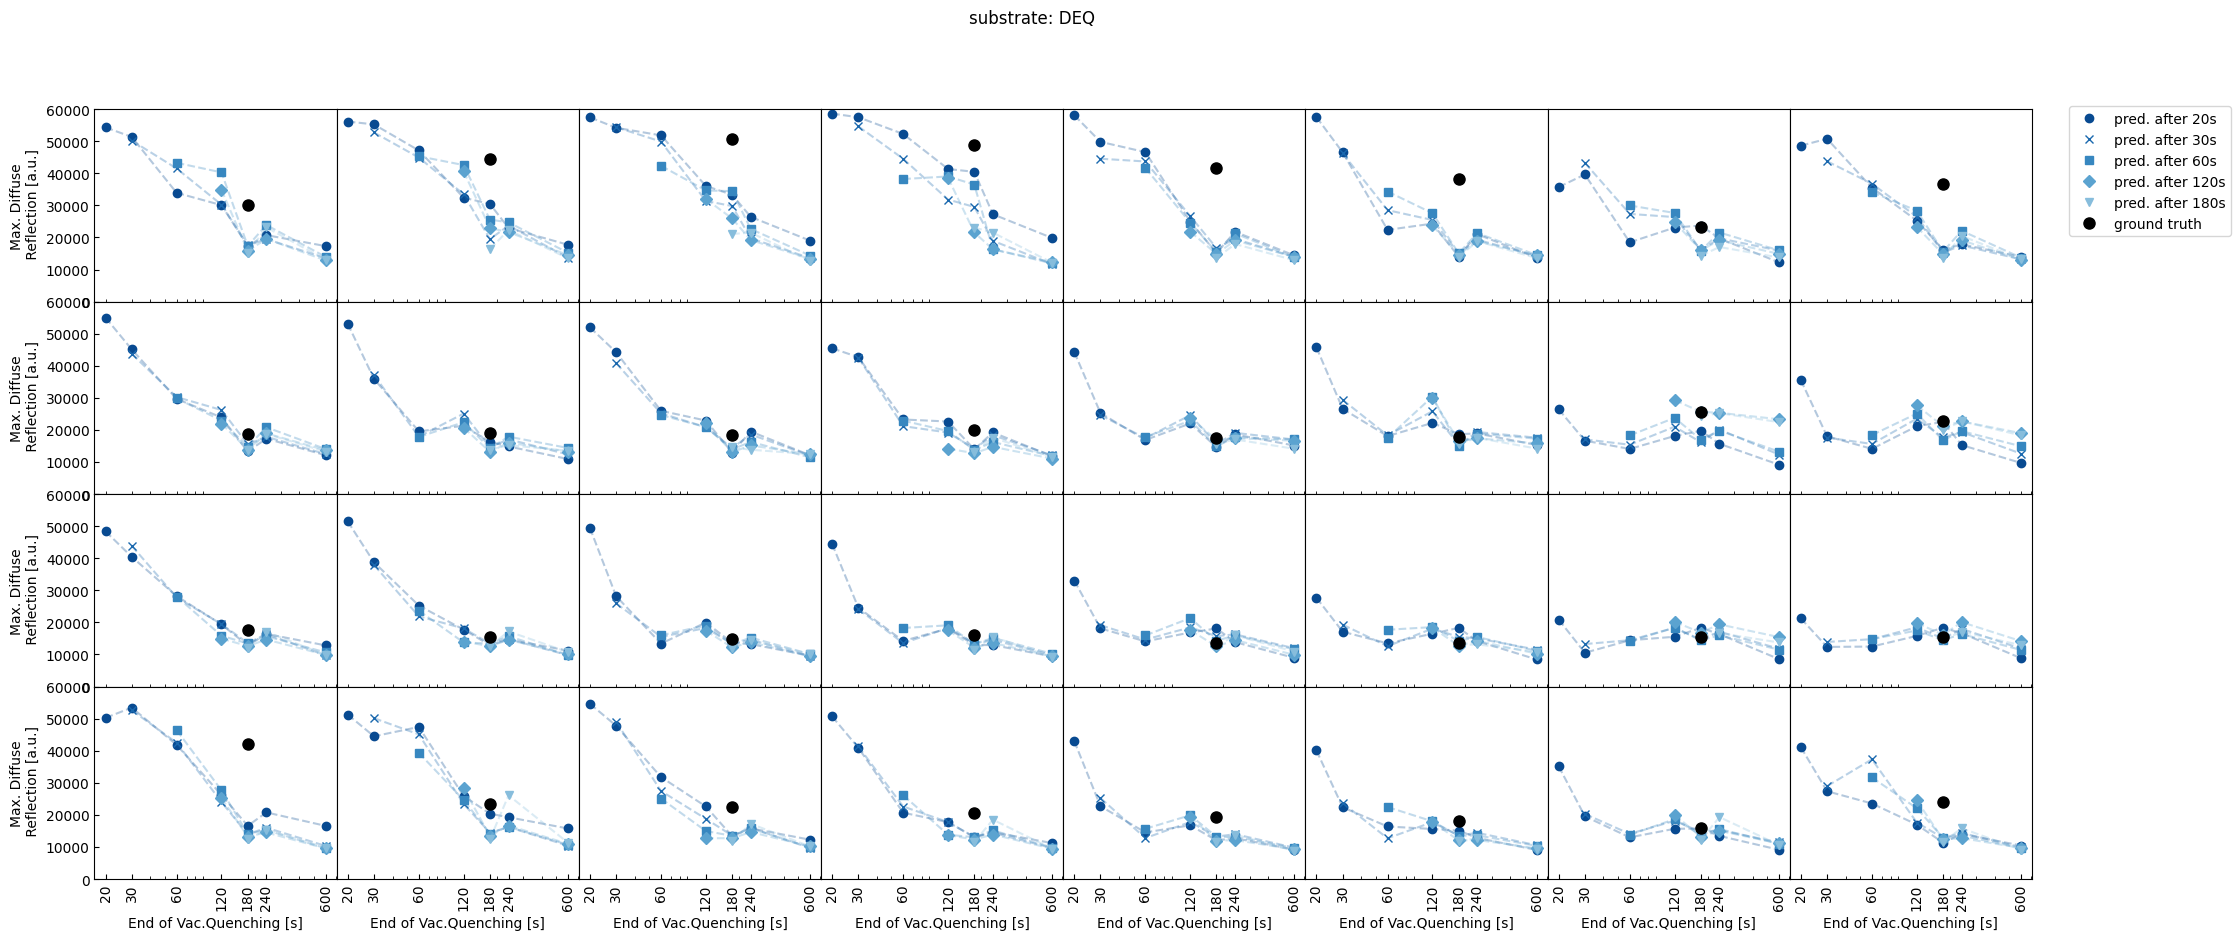

In [12]:
# For diffuse refection forecasting, only use ND signal
signals=["ND"]

# Loop through each unique experiment ID in the test dataset
for i_exp in range(len(sorted(testDF["expID"].unique()))):
    # Filter the test dataset for a specific experiment ID
    if sorted(testDF["expID"].unique())[i_exp]=="DEQ":
        # Filter the test data for the current experiment
        testingData=testDF[testDF["expID"]==sorted(testDF["expID"].unique())[i_exp]]
    
        
        fig,ax =plt.subplots(4,8, figsize=(25,10))
        fig.suptitle("substrate: " + str( sorted(testDF["expID"].unique())[i_exp]))
        
        # Iterate through each sample/patch on the current expID
        for inn in range(len(testingData)):
            # Extract the test sample
            testsample=testingData.loc[testingData.index[inn]]

            # Retrieve sample details
            patchID=testsample["patchID"]
            sample_evac_duration= int(testsample["evac_duration"])                                                 
            # Get the ground truth maximum diffuse reflection
            gt_signal= np.max(testsample["ND"][int(testsample["evac_duration"])-212:int(testsample["evac_duration"])-1])

            # Iterate over venting times up to the sample's evacuation duration
            for ix, venting in enumerate(ventings[:evac_durations.index(sample_evac_duration)+1]):
                # Initialize scaffolds for signals and their oscillations after venting            
                scaffold_signals=[[],[],[],[]]
                
                for i_signal, signal in enumerate(signals):
    
                    ls_preds=[]
                    list_endOscillation=[]   
                    for iy, evac_duration in enumerate(evac_durations[ix:]):
                        # Load the Random Forest model
                        modelsavepath="models/forecasting_models/" +str(signal)+"_"+ str(venting)+"_"+str(evac_duration)+".joblib"
                        rf_model = joblib.load(modelsavepath)
                        
                        # Extract the factual data up to the venting time
                        factual=testsample[signal][:venting]
                        # Predict/Forecast future signal values using the Random Forest model
                        y_pred=rf_model.predict([factual])
                        
                        # Adjust the prediction to align with the last known value
                        curve=y_pred[0]
                        slope=factual[-1]-factual[-2]
                        delta=curve[0]-(factual[-1]+slope)
                        y_pred[0]=curve-delta

                        # Store the predictions/forecasts
                        ls_preds.append(y_pred[0])
                        list_endOscillation.append(y_pred[0][-210:])
    
                    # Combine the factual data and forecast into a complete signal for each sample
                    for plotParam in range(len(ls_preds)):
                        scaffold_signal=np.concatenate((factual,ls_preds[plotParam],[0]*(1979-len(factual)-len(ls_preds[plotParam]))))
                        scaffold_signal=ls_preds[plotParam]
                        scaffold_signals[i_signal].append(scaffold_signal)
                        
                # Generate predictions of maximum diffuse reflection using random forest model
                list_of_predictions_scaffold=[]
                for i_gneratedSignal in range(len(scaffold_signals[0])):
                    partOfSignal=scaffold_signals[0][i_gneratedSignal]
                    maxDiffuseReflection=np.max(partOfSignal)           
                    list_of_predictions_scaffold.append(maxDiffuseReflection)
                    
                # Plot maximum diffuse reflection predictions     
                ax[location_dict[patchID]].plot(xticks[ix:],list_of_predictions_scaffold, marker=markerlist[ix],linestyle="None",color=color_list_fig_2[ix], label="pred. after "+ str(xticks[ix])+"s")
                ax[location_dict[patchID]].plot(xticks[ix:],list_of_predictions_scaffold, "--",color=color_list_fig_2[ix],alpha=0.3)
            
            # Plot ground truth maximum diffuse reflection         
            ax[location_dict[patchID]].plot(xticks[evac_durations.index(sample_evac_duration)], gt_signal, "ko", markersize=8,label="ground truth")
            ax[location_dict[patchID]].tick_params(axis='both', which='both',direction="in")   
        
        for coord in location_dict.values():
            ax[coord].set_ylim([0,60000])
            ax[coord].set_xscale('log')
        for col_num in range(8):
            ax[0,col_num].set_xticks([])
            ax[1,col_num].set_xticks([])
            ax[2,col_num].set_xticks([])
            ax[3,col_num].set_xticks([])
        for col_num in range(7):
            ax[0,col_num+1].set_yticks([])
            ax[1,col_num+1].set_yticks([])
            ax[2,col_num+1].set_yticks([])
            ax[3,col_num+1].set_yticks([])
        ax[0,7].legend(bbox_to_anchor=(1.85, 1.05)) 
        for row_num in range(4):
            ax[row_num,0].set_ylabel("Max. Diffuse\n Reflection [a.u.]") 
        for col_num in range(8):
            ax[3,col_num].set_xlabel("End of Vac.Quenching [s]") 
            ax[3,col_num].set_xticks(xticks, labels=xticks, rotation=90, minor=False)
        plt.subplots_adjust(wspace=0, hspace=0)    
        plt.show()

